In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import squidpy as sq
from transpa.eval_util import calc_corr
from transpa.util import leiden_cluster
import seaborn as sns
import os
import warnings
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, normalized_mutual_info_score, homogeneity_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
warnings.filterwarnings("ignore")


In [2]:
spatial_df_file = '../../data/ST/osmFISH/osmFISH_df.csv'
spatial_loom_file = '../../data/ST/osmFISH/osmFISH_SScortex_mouse_all_cells.loom'
spa_adata = sc.read_loom(spatial_loom_file)
spa_adata = spa_adata[~np.isin(spa_adata.obs.Region, ['Excluded', 'Hippocampus', 'Internal Capsule Caudoputamen','Ventricle', 'White matter'])].copy()
raw_spatial_df  = pd.read_csv(spatial_df_file)
spa_adata.X = raw_spatial_df.values
spa_adata.obsm['spatial'] = np.hstack([spa_adata.obs.X.values.reshape(-1,1), spa_adata.obs.Y.values.reshape(-1,1)])
df_spa = raw_spatial_df
sq.gr.spatial_neighbors(spa_adata)
sq.gr.spatial_autocorr(
    spa_adata,
    n_jobs=10,
)
imp_adatas = {}
eval_res = {'se_moranI':{}, 'pred_corr':{}, 'I':{}}
method_mapping = {'transImpute':"TransImp", 'transImpSpa':"TransImpSpa", 'transImpCls':"TransImpCls", 'transImpClsSpa':"TransImpClsSpa"}
output_root = "../../output"
for file in os.listdir(output_root):
    if file.split('_')[-1].split('.')[0] not in {'spaGE', 'transImpute', 'stPlus', 'Tangram', 'transImpSpa', 'transImpCls', 'transImpClsSpa'}: continue
    if len(file.split(".")[0].split('_')) != 3: continue    
    spa, rna, method = file.split(".")[0].split('_')
    if spa.lower() != 'osmfish' or rna.lower() != 'allenvisp': continue
    df_res = pd.read_csv(os.path.join(output_root,file), index_col=0)
    df_res = pd.read_csv(os.path.join(output_root,file), index_col=0)
    imp_adata = sc.AnnData(df_res.values)
    imp_adata.var_names = df_res.columns
    imp_adata.obsm['spatial'] = spa_adata.obsm['spatial']
    
    method = method if not method in method_mapping else method_mapping[method]
    imp_adatas[method] = imp_adata
    corrs = calc_corr(df_spa, df_res, df_res.columns, False, True)
    sq.gr.spatial_neighbors(imp_adata)
    sq.gr.spatial_autocorr(
        imp_adata,
        n_jobs=20,
        mode='moran',
    )
    sel = (~np.isnan(imp_adata.uns['moranI'].I))
    if np.sum(sel) < imp_adata.n_vars:
        print(f'({spa} {rna} {method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    squ_err_moranI = np.square(spa_adata.uns['moranI'].loc[imp_adata.var_names].I[sel] - imp_adata.uns['moranI'].I[sel])
    eval_res['se_moranI'][method] = squ_err_moranI
    eval_res['pred_corr'][method] = pd.Series(corrs, df_res.columns)
    eval_res['I'][method] = pd.Series(imp_adata.uns['moranI'].I[sel], df_res.columns)


In [3]:
TransImpSpa_reduced_err_wrt_tangram = np.median((eval_res['se_moranI']["Tangram"] - eval_res['se_moranI']["TransImpSpa"]) / eval_res['se_moranI']["Tangram"])
print(f"TransImpSpa avg. reduced err wrt tangram: {TransImpSpa_reduced_err_wrt_tangram:.3}")

TransImpSpa avg. reduced err wrt tangram: 0.469


In [4]:
df_se_moranI = pd.DataFrame(dict(sorted(eval_res['se_moranI'].items())))
df_corr      = pd.DataFrame(dict(sorted(eval_res['pred_corr'].items())))
df_I         = pd.DataFrame(dict(sorted(eval_res['I'].items())))
df_I['truth'] = spa_adata.uns['moranI'].loc[df_I.index.values,:].I
imp_adatas = dict(sorted(imp_adatas.items()))

<AxesSubplot: >

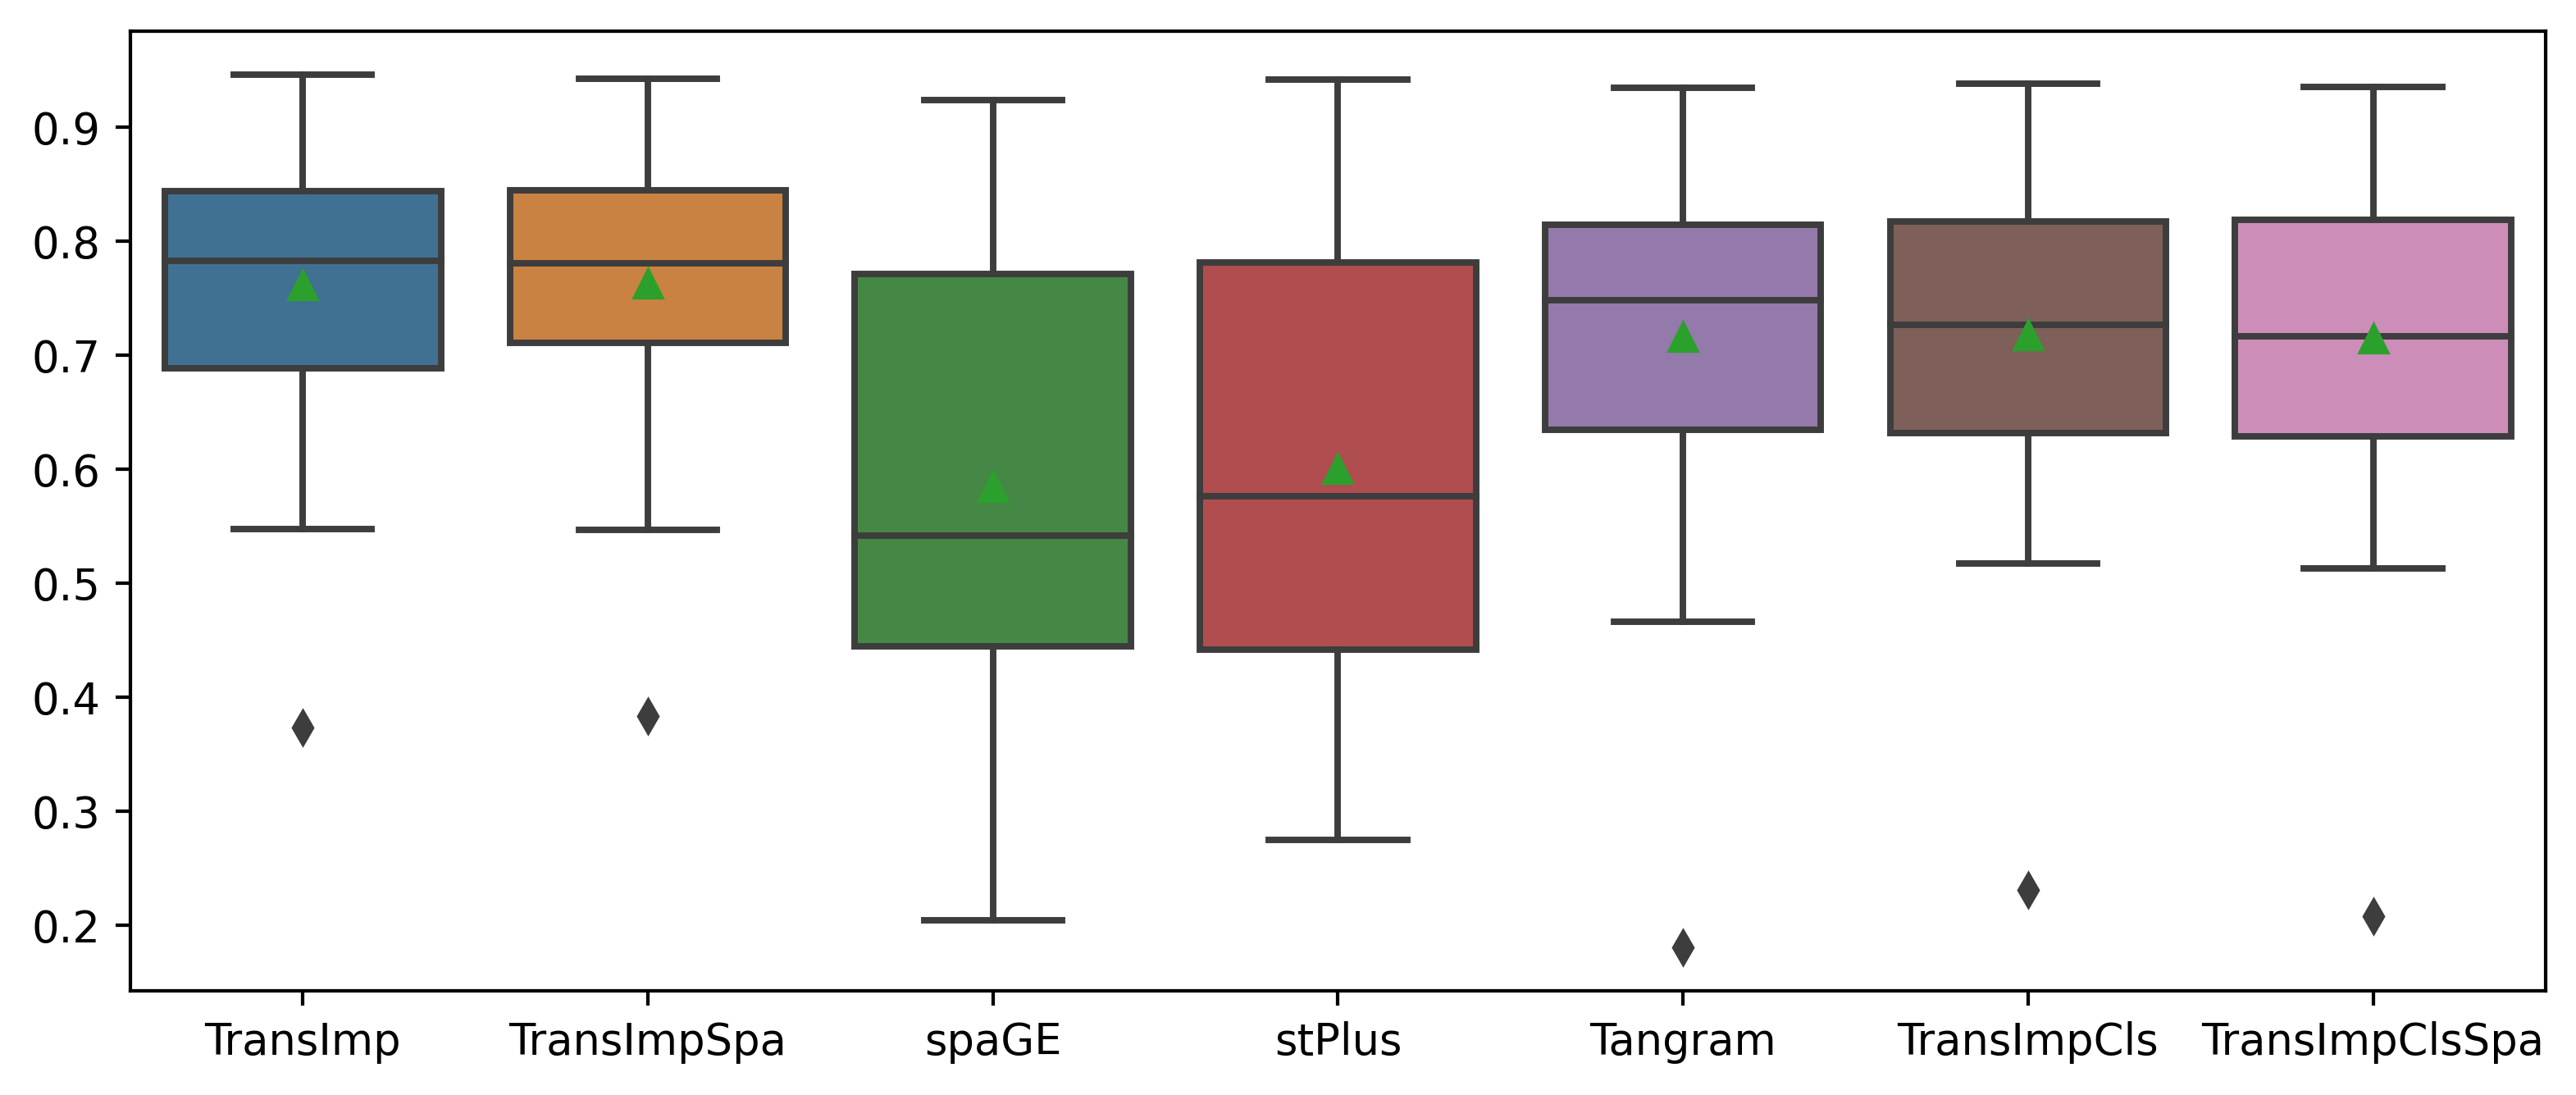

In [5]:
plt.figure(figsize=(10, 4), dpi= 380)
method_order = ["TransImp", "TransImpSpa", "spaGE", "stPlus", "Tangram", "TransImpCls", "TransImpClsSpa"]
color = ['#3274A1', '#E1812C', '#3A923A', '#C03D3E', '#9372B2', '#845B53', '#D684BD', '#c780e8']
sns.boxplot(data = df_corr, showmeans=True, order=method_order, palette=color)

<AxesSubplot: >

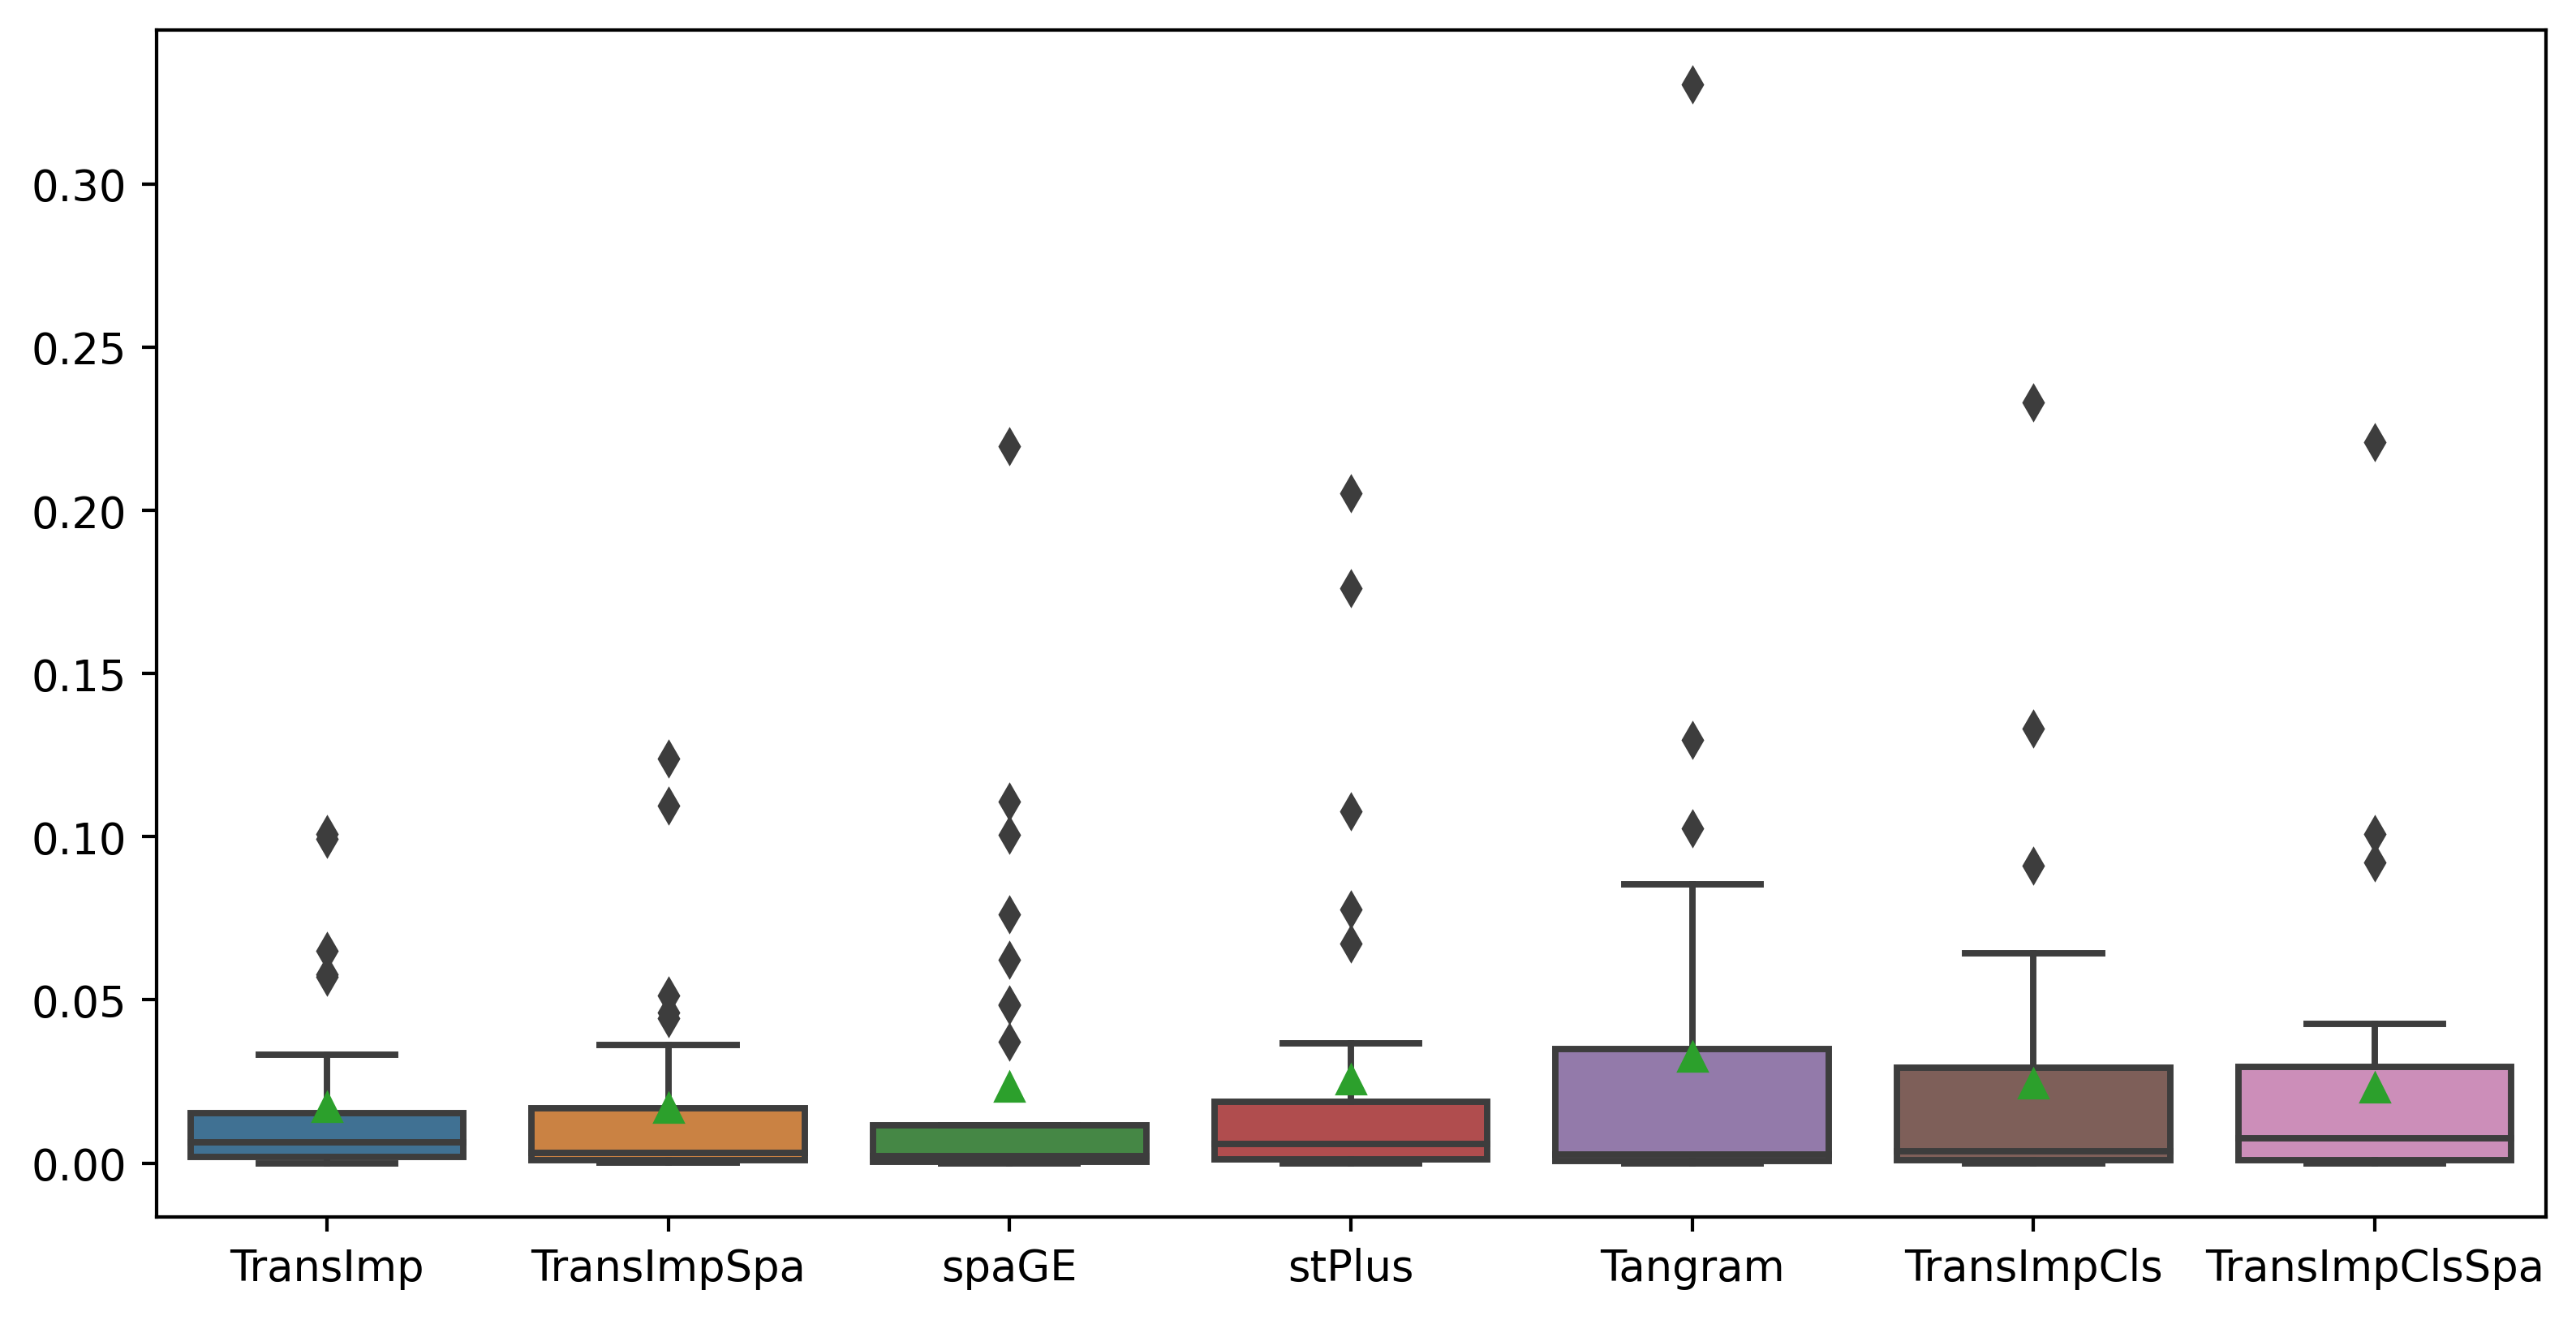

In [6]:
plt.figure(figsize=(10, 5), dpi= 380)
sns.boxplot(data = df_se_moranI, showmeans=True, order=method_order, palette=color)

In [7]:
n_clusters = len(spa_adata.obs.ClusterName.unique())
print(f"{n_clusters} clusters")

real_clss = AgglomerativeClustering(n_clusters=n_clusters, 
                                         connectivity=spa_adata.obsp['spatial_connectivities'],
                                         ).fit_predict(StandardScaler().fit_transform(spa_adata.X))
spa_cluster_metrics = {}                                         
for method in sorted(imp_adatas.keys()):
    imp_adata = imp_adatas[method]
    pred_clss = AgglomerativeClustering(n_clusters=n_clusters, 
                                         connectivity=spa_adata.obsp['spatial_connectivities'],
                                         ).fit_predict(StandardScaler().fit_transform(imp_adata.X))
    ars = adjusted_rand_score(real_clss, pred_clss)
    amis = adjusted_mutual_info_score(real_clss, pred_clss)
    homo = homogeneity_score(real_clss, pred_clss)
    nmi = normalized_mutual_info_score(real_clss, pred_clss)
    spa_cluster_metrics[method] = {"ARS":ars, "AMIS":amis, 'HOMO': homo, 'NMI':nmi}
    pd.DataFrame(spa_cluster_metrics).to_csv("../../output/clustering/osmFISH_AllenVISp.csv")
    print(f"Cluster on Raw Expression vs  on {method} Predicted Expression\n - ARS: {ars:.6f}, AMIS: {amis:.6f}, HOMO: {homo:.6f}, NMI: {nmi:.6f}")

31 clusters
Cluster on Raw Expression vs  on Tangram Predicted Expression
 - ARS: 0.392681, AMIS: 0.586255, HOMO: 0.606999, NMI: 0.599525
Cluster on Raw Expression vs  on TransImp Predicted Expression
 - ARS: 0.510734, AMIS: 0.658584, HOMO: 0.650551, NMI: 0.669939
Cluster on Raw Expression vs  on TransImpCls Predicted Expression
 - ARS: 0.383249, AMIS: 0.615758, HOMO: 0.632907, NMI: 0.628872
Cluster on Raw Expression vs  on TransImpClsSpa Predicted Expression
 - ARS: 0.421628, AMIS: 0.632704, HOMO: 0.655309, NMI: 0.645584
Cluster on Raw Expression vs  on TransImpSpa Predicted Expression
 - ARS: 0.361685, AMIS: 0.616148, HOMO: 0.652268, NMI: 0.629271
Cluster on Raw Expression vs  on spaGE Predicted Expression
 - ARS: 0.334547, AMIS: 0.598532, HOMO: 0.549881, NMI: 0.609854
Cluster on Raw Expression vs  on stPlus Predicted Expression
 - ARS: 0.352693, AMIS: 0.571912, HOMO: 0.481139, NMI: 0.583553
